# King County House Sales Price Prediction

![image](https://storage.googleapis.com/kaggle-datasets-images/128/270/d149695d1f9a97ec54cf673be6430ad7/dataset-cover.jpg)

## Table of Contents

* [1. Required Libraries](#1)
* [2. Exploratory Data Analysis](#2)
    * [2.1. Univariate Analysis](#2-1)
    * [2.2. Multivariate Analysis](#2-2)
    * [2.3. Correlation Analysis](#2-3)
* [3. Predicting House Prices](#3)
    * [3.1. Data Preprocessing](#3-1)
    * [3.2. Train/Test Split](#3-2)
    * [3.3. Outlier Removal](#3-3)
    * [3.4. Model Selection](#3-4)

## <a id="1"></a> 1. Required Libraries

In [1]:
import math
import random
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn import clone
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
    PolynomialFeatures,
    FunctionTransformer,
    PowerTransformer
)
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor


import warnings
warnings.filterwarnings("ignore")

seed = 42
random.seed(seed)
np.random.seed(seed)

sns.set_style("darkgrid")

In [2]:
df = pd.read_csv("kc_house_data.csv")
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [3]:
df.shape

(21613, 21)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

By the information above, our dataset don't have empty values. Most of the features seems to have the correct data type, but the _date_ and _zipcode_ must be converted. Also we will remove duplicated rows if any exists.

In [5]:
df.drop(["id"], axis=1, inplace=True) # removing unused feature

df["date"] = pd.to_datetime(df["date"], format="%Y%m%d", exact=False) # converting date to datetime format

df["zipcode"] = df["zipcode"].astype(str) # converting zipcode to string type

df.drop_duplicates(inplace=True, keep="first") # removing duplicated rows

Now we will be inspecting the values from each column in order to understand the features values and meaning and to find errors.

In [6]:
for col in df.columns:
    print(f"{col}:")
    if df[col].nunique() >= 10:
        print(f"[{df[col].min()} ... {df[col].max()}]")
    else:
        print(df[col].unique())
        
    print("\n")

date:
[2014-05-02 00:00:00 ... 2015-05-27 00:00:00]


price:
[75000.0 ... 7700000.0]


bedrooms:
[0 ... 33]


bathrooms:
[0.0 ... 8.0]


sqft_living:
[290 ... 13540]


sqft_lot:
[520 ... 1651359]


floors:
[1.  2.  1.5 3.  2.5 3.5]


waterfront:
[0 1]


view:
[0 3 4 2 1]


condition:
[3 5 4 1 2]


grade:
[1 ... 13]


sqft_above:
[290 ... 9410]


sqft_basement:
[0 ... 4820]


yr_built:
[1900 ... 2015]


yr_renovated:
[0 ... 2015]


zipcode:
[98001 ... 98199]


lat:
[47.1559 ... 47.7776]


long:
[-122.519 ... -121.315]


sqft_living15:
[399 ... 6210]


sqft_lot15:
[651 ... 871200]




Looking at the summary above, we could not determine the presence of errors in the data, so we will continue to the data exploration step.

## <a id="2"></a>2. Exploratory Data Analysis

In this section we will dive deep into the data in order to understand each feature distribution and values and to find relationships between them. Also we will look for the most proeminent input features for the house price prediction regression task.

### <a id="2-1"></a>2.1. Univariate Analysis

In [7]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,47.560053,-122.213896,1986.552492,12768.455652
std,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,0.138564,0.140828,685.391304,27304.179631
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,47.678000,-122.125000,2360.000000,10083.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,47.777600,-121.315000,6210.000000,871200.000000


Since we don't have many features, we will start plotting histograms for each column, so we can get to know their distribution and values.

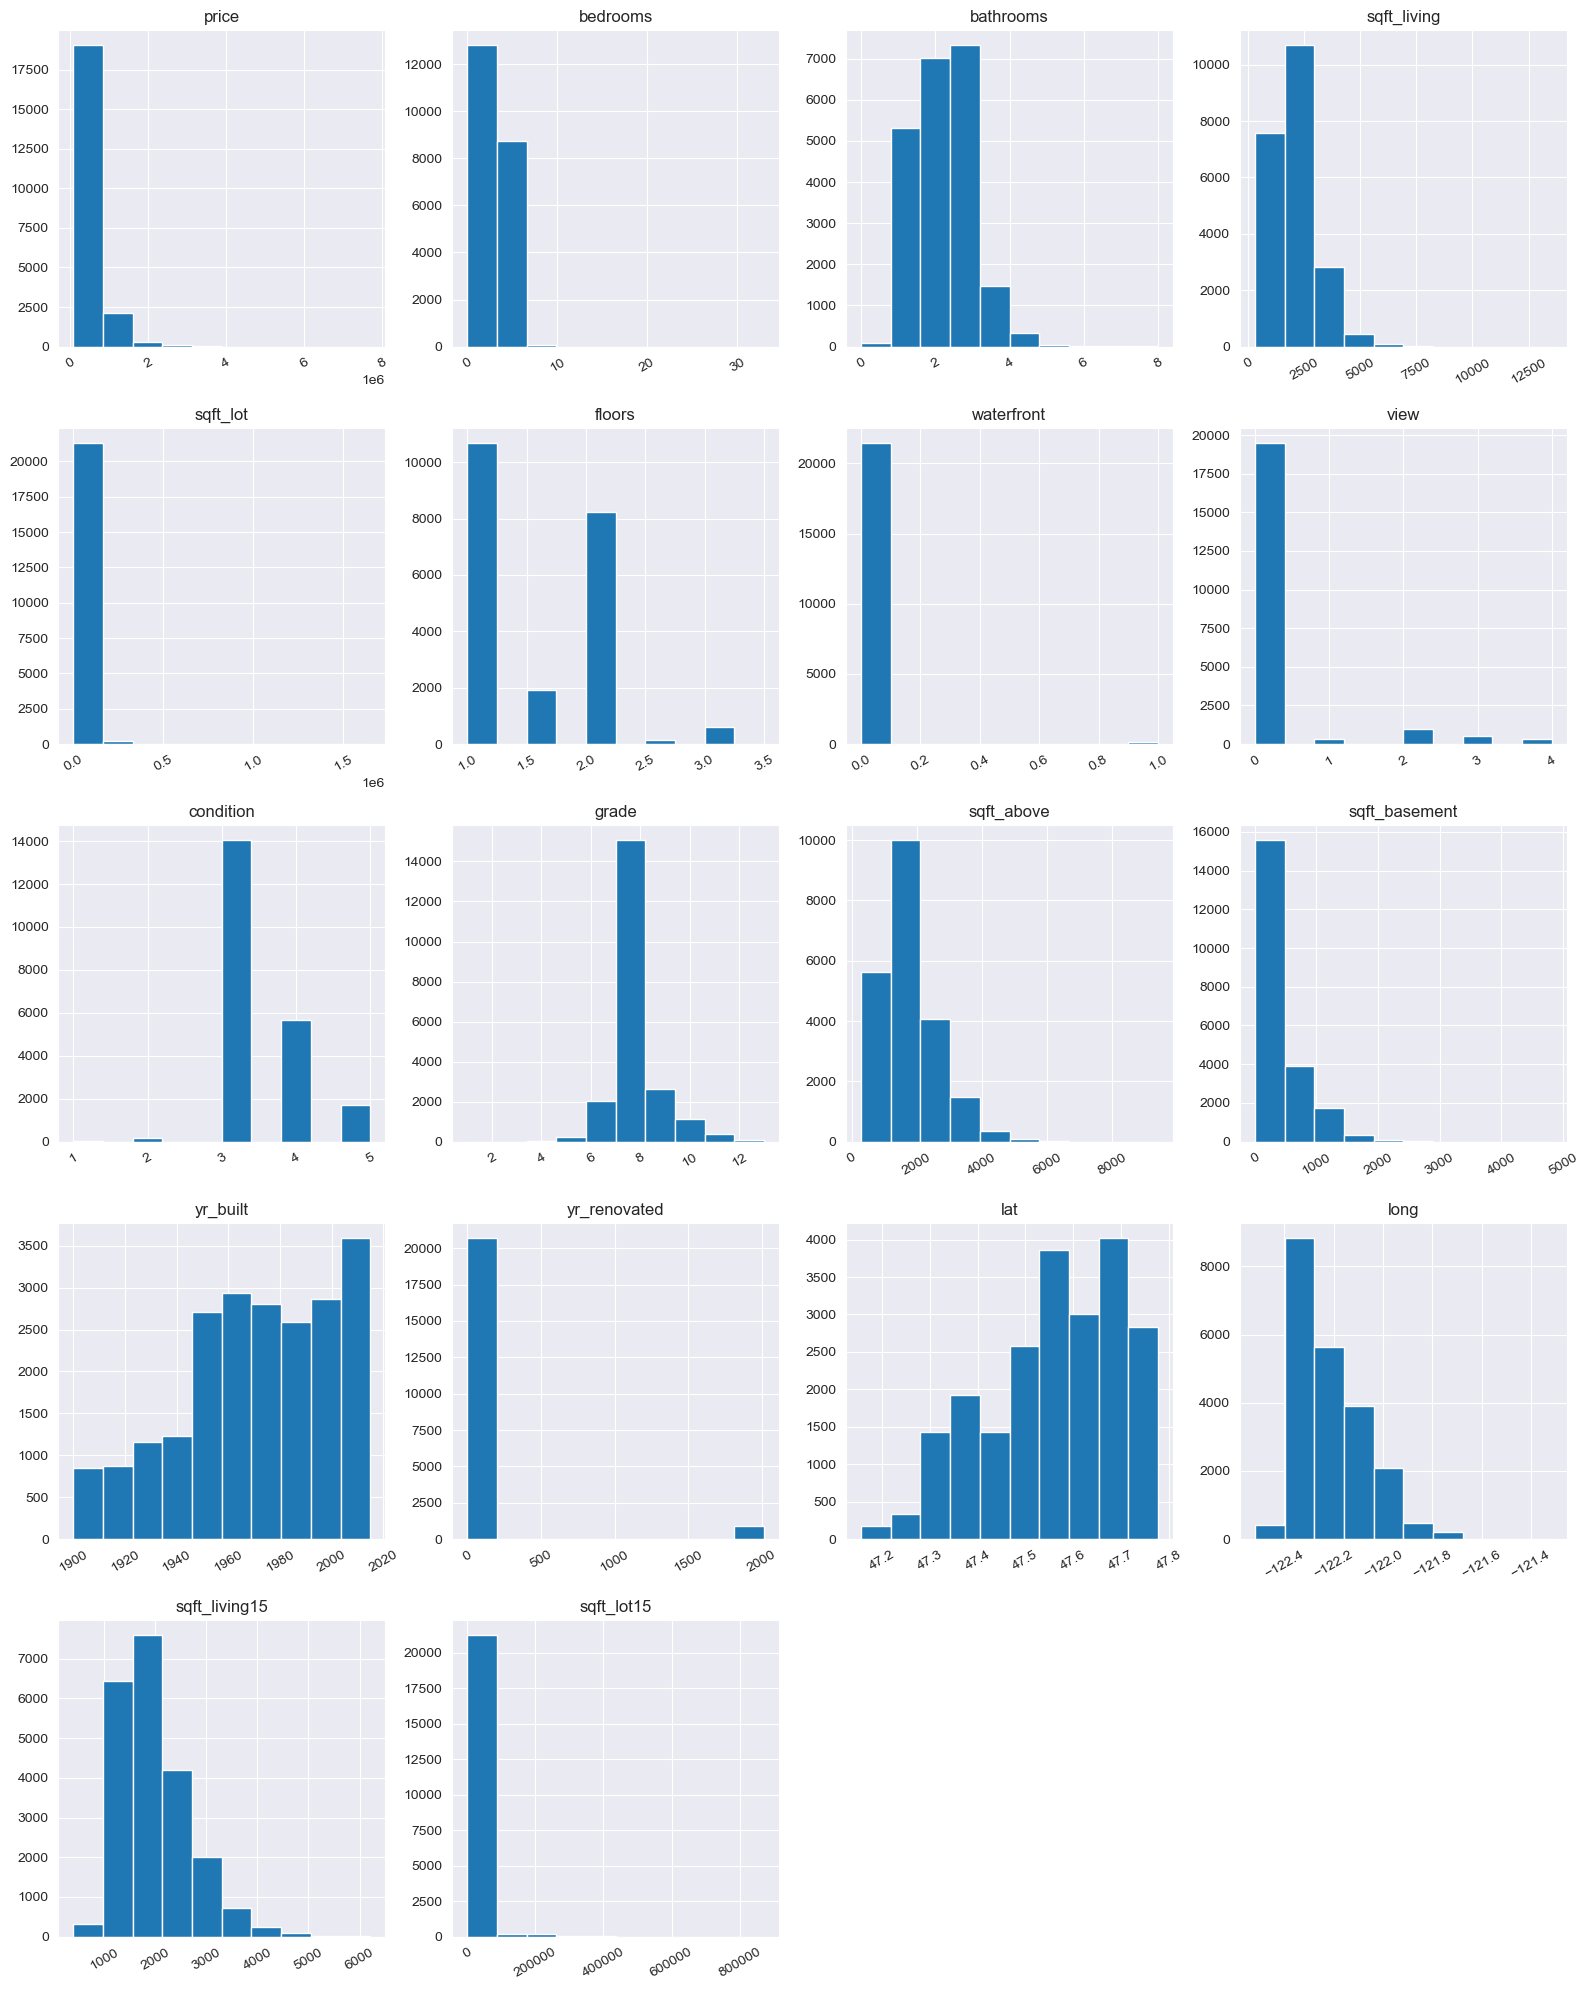

In [8]:
numeric_features = df.select_dtypes(include=[int, float]).columns.to_list()
n_cols = 4
n_rows = math.ceil(len(numeric_features) / n_cols)

fig = plt.figure(figsize=(n_cols * 4, n_rows * 4))
for i, feature in enumerate(numeric_features):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.title(feature)
    plt.hist(df[feature])
    plt.xticks(rotation=30)

plt.tight_layout()
plt.show()

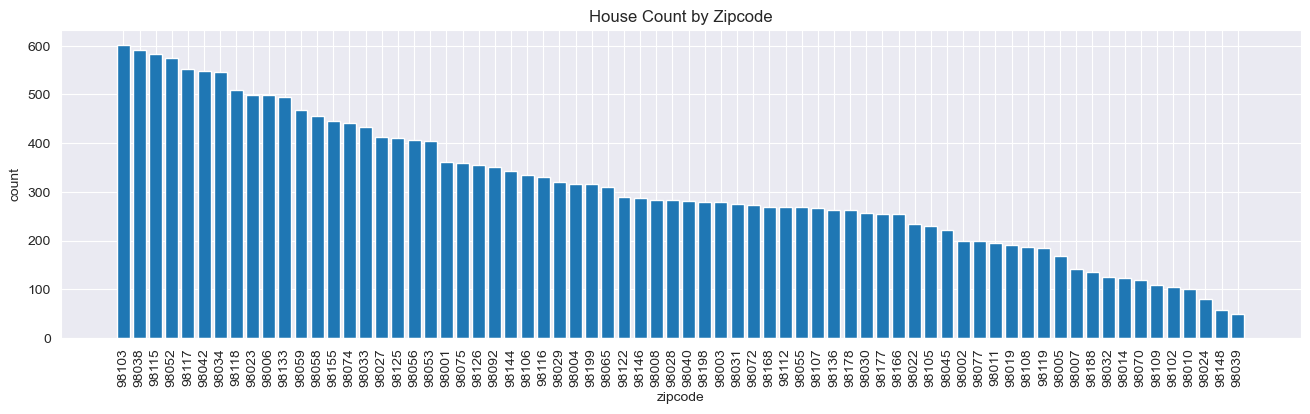

In [9]:
zipcode_counts = df["zipcode"].value_counts().sort_values(ascending=False)
plt.figure(figsize=(16, 4))
plt.bar(x=zipcode_counts.index, height=zipcode_counts)
plt.xticks(rotation=90)
plt.title("House Count by Zipcode")
plt.xlabel("zipcode")
plt.ylabel("count")
plt.show()

As we can observe in the graphs above, some features are highly skewed. This can be an indication of the presence of **outliers** in the data. Also, the majority of the houses included in this dataset are in a good conditions, containing from 2 to 3 bedrooms and bathrooms in average. We can assume that the extreme values observed in some features are from luxury or boarding like houses.

### <a id="2-2"></a>2.2. Multivariate Analysis

Considering that most of our features are numeric, we will start by looking for relationships between the input features and our target (price).

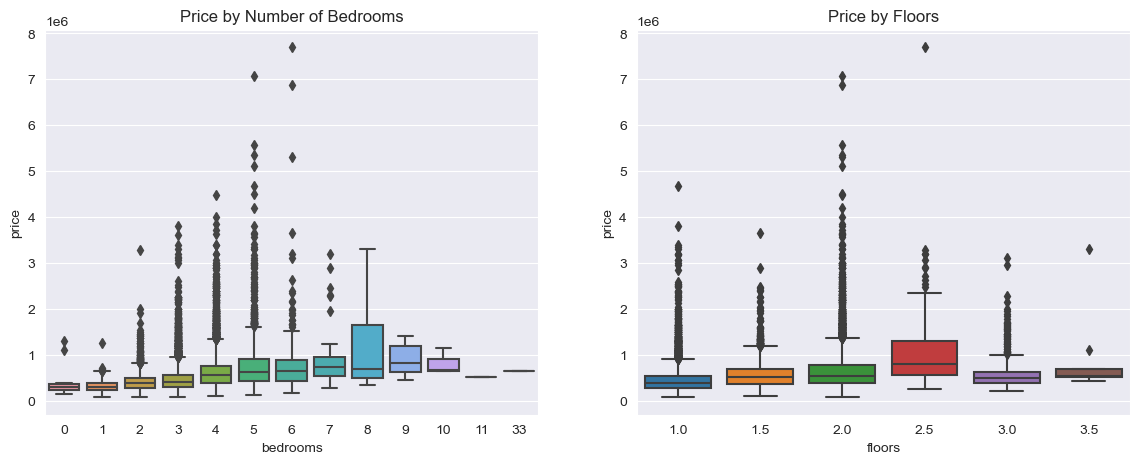

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.set_title("Price by Number of Bedrooms")
sns.boxplot(
    data=df,
    x="bedrooms",
    y="price",
    ax=ax
)

ax = axes[1]
ax.set_title("Price by Floors")
sns.boxplot(
    data=df,
    x="floors",
    y="price",
    ax=ax
)

fig.show()

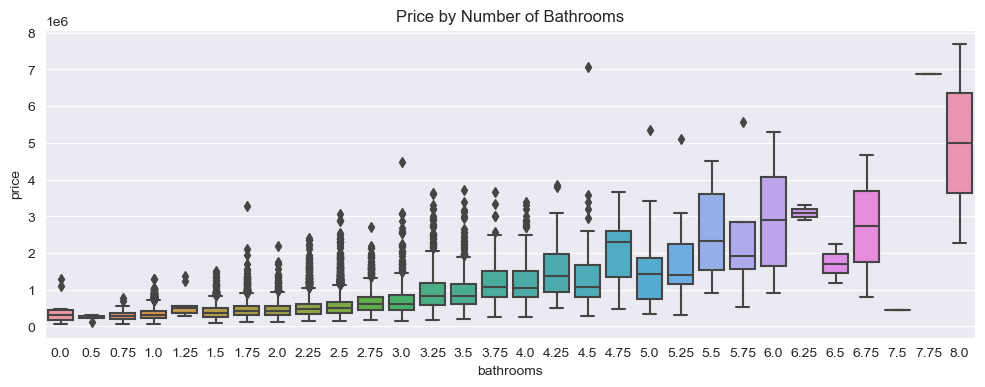

In [11]:
plt.figure(figsize=(12, 4))
plt.title("Price by Number of Bathrooms")
sns.boxplot(
    data=df,
    x="bathrooms",
    y="price"
)
plt.show()

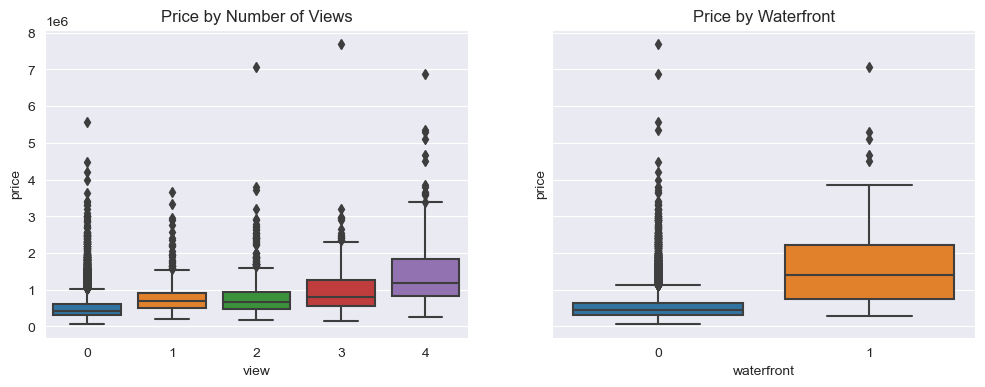

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
ax = axes[0]
ax.set_title("Price by Number of Views")
sns.boxplot(
    data=df,
    x="view",
    y="price",
    ax=ax
)

ax = axes[1]
ax.set_title("Price by Waterfront")
sns.boxplot(
    data=df,
    x="waterfront",
    y="price",
    ax=ax
)

fig.show()

By the analysis of the _boxplots_ above we cannot see a clear linear relationship between the number of bedrooms, bathrooms, floors and views with the price variable. Also, the houses with waterfront have higher average prices, but they are minority, as we saw in the univariate analysis.

<Axes: xlabel='sqft_lot15', ylabel='price'>

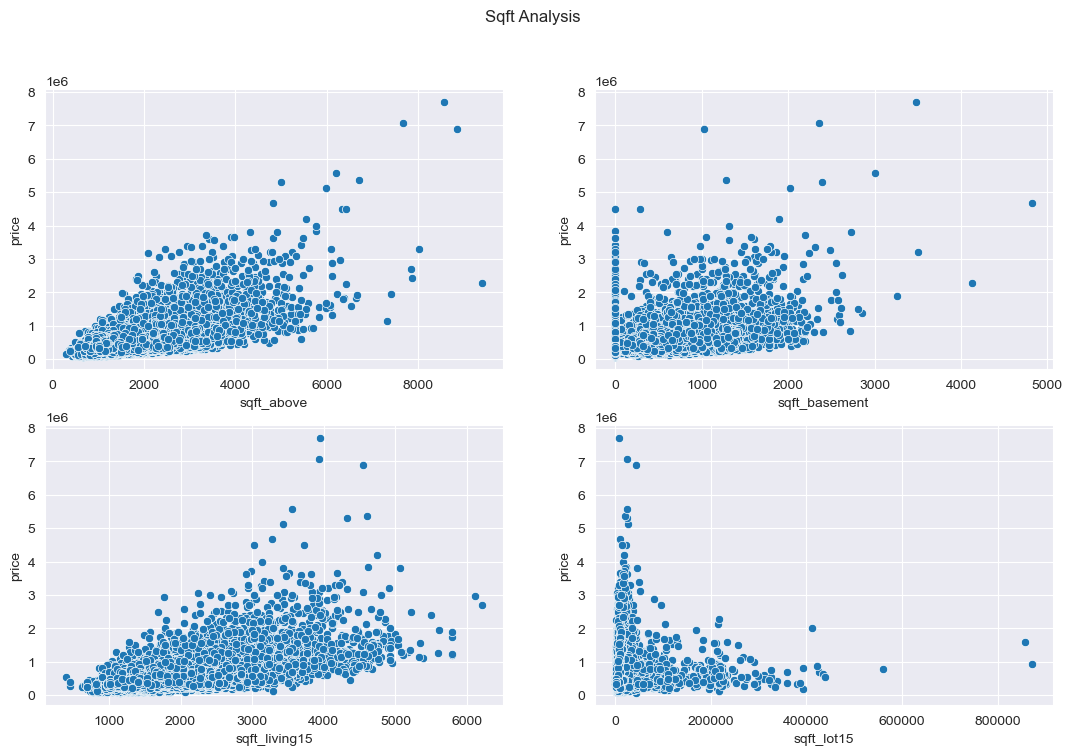

In [13]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(13, 8))

fig.suptitle("Sqft Analysis")

sns.scatterplot(data=df, x="sqft_above", y="price", ax=ax0)
sns.scatterplot(data=df, x="sqft_basement", y="price", ax=ax1)
sns.scatterplot(data=df, x="sqft_living15", y="price", ax=ax2)
sns.scatterplot(data=df, x="sqft_lot15", y="price", ax=ax3)

It seems that the features of area measurements in square feets have little correlation with the _price_ target. It's common to the price of a house to be related with its total area, so we will analyse if that is the case.

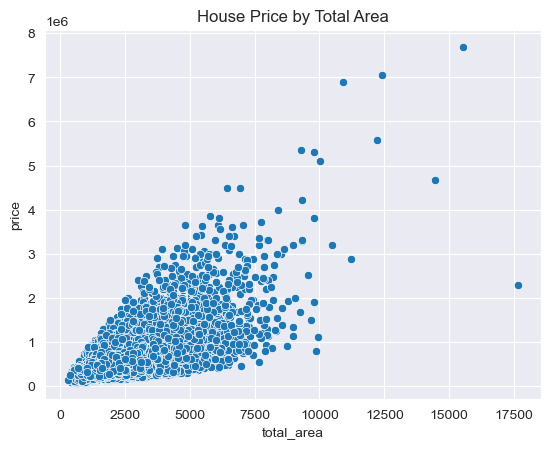

In [14]:
total_area = df["sqft_basement"] + df["sqft_living"]
sns.scatterplot(x=total_area, y=df["price"])
plt.title("House Price by Total Area")
plt.xlabel("total_area")
plt.ylabel("price")
plt.show()

As we can see, the linear relationship in this case is much stronger, so we may include this feature in the prediction section.

### <a id="2-3"></a>2.3. Correlation Analysis

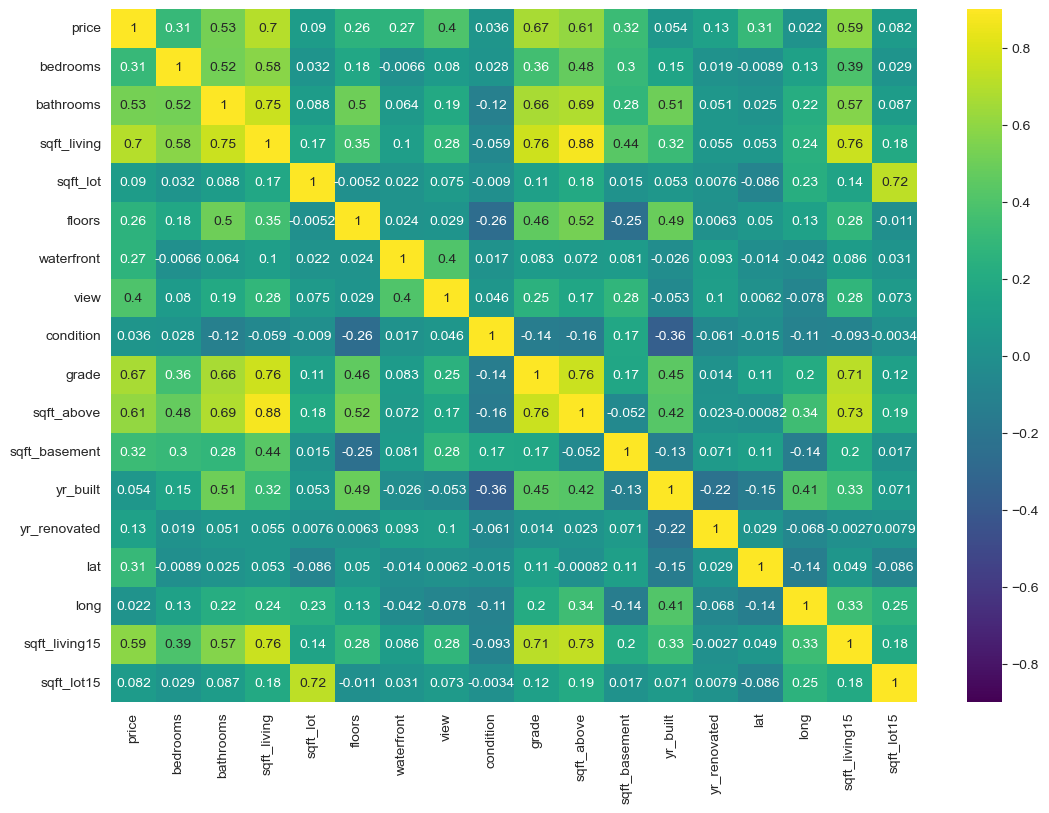

In [15]:
corr = df.corr()
plt.figure(figsize=(13, 9))
sns.heatmap(corr, cmap="viridis", vmin=-0.9, vmax=0.9, annot=True)
plt.show()

The heatmap above indicate some strong correlations between the dataset features. Strong correlations between the input features can negatively impact our models performances because of the problem of _multicolinearity_. In this context we can highlight some of the highly correlated pairs:

* _sqft_living_ and _sqft_above_
* _sqft_living_ and _sqft_living15_
* _sqft_lot_ and _sqft_lot15_
* _sqft_living_ and _grade_
* _sqft_above_ and _bathrooms_

Also, some features are strong candidates for _price_ prediction (e.g. _sqft_living_, _sqft_above_ and _grade_) because of the strong linear relationship they have with our target variable. They are: _sqft_living_, _grade_ and _sqft_above_.

## <a id="3"></a>3. Predicting House Prices

In this section, we will build machine learning models to predict the prices of houses in King County.
Let's begin with some function definitions for model evaluation.

In [16]:
def plot_residuals(y_true, y_pred):
    residuals = y_pred - y_true
    plt.figure(figsize=(6, 4))
    plt.title("Residual Plot")
    plt.scatter(np.arange(len(residuals)), residuals)
    plt.axhline(0, linestyle="--", color="red")
    plt.xlabel("predictions")
    plt.ylabel("residuals")
    max_resid = np.abs(residuals).max()
    plt.ylim((-1 * (max_resid + 1), (max_resid + 1)))
    plt.show()

def metrics(y_true, y_pred):
    r2 = np.round(r2_score(y_true, y_pred), 2)
    mse = np.round(mean_squared_error(y_true, y_pred), 2)
    rmse = np.round(np.sqrt(mse), 2)
    mae = np.round(mean_absolute_error(y_true, y_pred), 2)

    return r2, rmse, mae

### <a id="3-1"></a>3.1. Data Preprocessing

In the EDA section we found that some of the input features are highly correlated between them, and this cause problems in some linear models.

In [17]:
def preprocess(df: pd.DataFrame):
    df = df.copy()
    to_drop = []

    #Feature Extraction
    df["age"] = df["date"].dt.year - df["yr_built"] #age: house age in years
    df["sqft_total"] = df["sqft_living"] + df["sqft_basement"] #sqft_total: total area (sqft_living + sqft_basement)
    to_drop.extend([
        "date",
        "yr_built",
        "sqft_living",
        "sqft_basement"
    ])

    # dropping high correlated features to avoid multicolinearity in linear models
    to_drop.extend([
        "sqft_above",
        "sqft_living15",
        "sqft_lot15",
        "grade"
    ])

    # dropping unused features
    to_drop.append("zipcode")

    df.drop(to_drop, axis=1, inplace=True)

    return df

df_prep = preprocess(df)

### <a id="3-2"></a>3.2. Train/Test Split

In [18]:
X = df_prep.drop(["price"], axis=1)
y = df_prep["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(X_train.shape)
print(X_test.shape)

(15129, 12)
(6484, 12)


### <a id="3-3"></a>3.3. Outlier Removal

As we observed in the EDA phase, our dataset contains a significant amount of outliers. Outliers can decrease some models performances, so we will remove some of them based on _price_ values. For this purpose we will use the interquartile method.

In [19]:
# removing outliers

q1 = np.percentile(y_train, 25)
q3 = np.percentile(y_train, 75)
iqr = q3 - q1
threshold = 1.5

outliers = y_train[(y_train < q1 - (threshold * iqr)) | (y_train > q3 + (threshold * iqr))]
X_train.drop(outliers.index, axis=0, inplace=True)
y_train.drop(outliers.index, inplace=True)

print(X_train.shape)
print(y_train.shape)

(14330, 12)
(14330,)


### <a id="3-4"></a>3.4. Model Selection

In order to select the best model to our regression task, first we will define a **base model** to assist our efforts to improve prediction performance. Base models are usually very simple models with few degrees of freedom, so in our case we will use **LinearRegression** model.

In [20]:
# scalers
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

# feature transformers
yeojohnson_transformer = PowerTransformer(method="yeo-johnson")
boxcox_transformer = PowerTransformer(method="box-cox")
log_transformer = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)

# skewed features (need transformation)
numeric_features = X_train.select_dtypes(include=[int, float]).columns.to_list()
skewed_features = [col for col in numeric_features if X_train[col].skew() >= 0.5]

mean_imputer = SimpleImputer(strategy="mean")

preprocessing = ColumnTransformer([
    ("imputer", mean_imputer, numeric_features),
    ("lat_lng_normalizer", yeojohnson_transformer, ["lat", "long"]),
    ("normalizer", log_transformer, list(set(skewed_features) - set(["lat", "long"])))
], remainder="passthrough")

In [21]:
from sklearn.calibration import cross_val_predict

regressor = TransformedTargetRegressor(
    regressor=LinearRegression(),
    transformer=log_transformer
)

base_model = Pipeline([
    ("preprocess", preprocessing),
    ("scaler", standard_scaler),
    ("reg", regressor)
])

train_preds = cross_val_predict(
    base_model,
    X_train,
    y_train,
    method="predict",
    n_jobs=-1
)

r2, rmse, mae = metrics(y_train, train_preds)
pd.DataFrame({
    "R^2": [r2],
    "RMSE": [rmse],
    "MAE": [mae]
})

,R^2,RMSE,MAE
0,0.62,127292.64,93505.77


 Now that we have a base model and a base score value (root mean squared error), we will try more complex and powerful regression models trying to obtain higher regression performances.

In [22]:
from sklearn.model_selection import GridSearchCV


models = {
    "KNeighborsRegressor": {
        "model": Pipeline([
            ("scaler", standard_scaler),
            ("reg", KNeighborsRegressor())
        ]),
        "params": {
            "reg__n_neighbors": np.arange(3, 30)
        }
    },
    "RandomForestRegressor": {
        "model": RandomForestRegressor(random_state=seed),
        "params": {
            "n_estimators": np.arange(500, 2000, 100),
            "max_depth": np.arange(2, 6)
        }
    },
    "XGBRegressor": {
        "model": XGBRegressor(),
        "params": {
            "n_estimators": np.arange(500, 2000, 100),
            "max_depth": np.arange(2, 6)
        }
    },
    "LGBMRegressor": {
        "model": LGBMRegressor(random_state=seed),
        "params": {
            "n_estimators": np.arange(500, 2000, 100),
            "max_depth": np.arange(2, 6)
        }
    }
}

names, r2, rmse, mae = [], [], [], []
for model_name, item in models.items():
    model = item["model"]
    param_grid = item["params"]

    
    gscv = GridSearchCV(
        model,
        param_grid=param_grid,
        n_jobs=-1,
        scoring="neg_mean_squared_error"
    )

    gscv.fit(X_train, y_train)

    print(model_name, ": best score of ", np.sqrt(-1 * gscv.best_score_), " with params ", gscv.best_params_)

KNeighborsRegressor : best score of  108713.6519383521  with params  {'reg__n_neighbors': 10}
RandomForestRegressor : best score of  115223.24216206369  with params  {'max_depth': 5, 'n_estimators': 1800}
XGBRegressor : best score of  83795.08018520784  with params  {'max_depth': 4, 'n_estimators': 500}
LGBMRegressor : best score of  81072.03595681094  with params  {'max_depth': 5, 'n_estimators': 500}
